In [1]:
from data.custom import CustomTrain, CustomTest
from models.vqgan import VQMultiModel
from models.vit import DifficultyViT, NDPViT
from data.utils import custom_collate
import torch

tokenizer = VQMultiModel.load_from_checkpoint("./imagenet/model/last.ckpt")
tokenizer.to("cuda")
tokenizer.eval()

diffvit = DifficultyViT.load_from_checkpoint("./imagenet/diffvit/last.ckpt", vocab_size=5120, resolutions=[1, 2, 4, 8, 16], hidden_dim=512, depth=1, heads=8, mlp_dim=1024, dim_head=128)
diffvit.to("cuda")
diffvit.eval()

ndpvit = NDPViT.load_from_checkpoint("./imagenet/ndpvit/last.ckpt", vocab_size=5120, resolutions=[1, 2, 4, 8, 16], hidden_dim=768, depth=12, heads=12, mlp_dim=1536, dim_head=64)
ndpvit.to("cuda")
ndpvit.eval()




/mnt/ndp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/ndp/.venv/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Working with z of shape (1, 1024, 16, 16) = 262144 dimensions.


/mnt/ndp/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/ndp/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/mnt/ndp/modules/losses/lpips.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more de

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 1024, 16, 16) = 262144 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


NDPViT(
  (token_embedding): Embedding(5120, 768)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-11): 12 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (to_qkv): Linear(in_features=768, out_features=2304, bias=False)
          (to_out): Linear(in_features=768, out_features=768, bias=False)
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=768, out_features=1536, bias=True)
            (2): GELU(approximate='none')
            (3): Linear(in_features=1536, out_features=768, bias=True)
          )
        )
      )
    )
  )
  (linear_head): Sequential(
    (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=768, out_features=5120, bias=True)
  )
  (tokenizer): VQMultiModel(
    (encoder_1): Encoder(
      (conv_in): Conv2d(3, 128, kernel_size=

Time for iteration 1: 0.02s
Total time so far: 0.02s
tokens tensor([[ 953, 1067, 1155, 1102, 1643,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0

Time for iteration 16: 0.02s
Total time so far: 0.25s
tokens tensor([[ 953, 1067, 1155, 1102, 1643, 2442, 2863, 2863, 2552, 3008, 3008, 3008,
         2541, 2407, 2850, 2525, 2169, 2705, 2939, 2545, 2545,    0,    0,    0,
            0, 3828, 3599, 3620, 3780, 3079, 3523, 3130, 3355,    0,    0,    0,
            0, 3917, 3620, 3622, 3867,    0,    0,    0,    0, 3509, 3202, 3804,
         3617, 3619, 3619, 3235, 4058, 3276, 3622, 3258, 3254,    0,    0,    0,
            0, 3867, 3688, 3235, 3526,    0,    0,    0,    0, 3658, 3688, 3978,
         3514, 4068, 4036, 3978, 3905, 4065, 3937, 3937, 3569, 4021, 3079, 3895,
         3932,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    

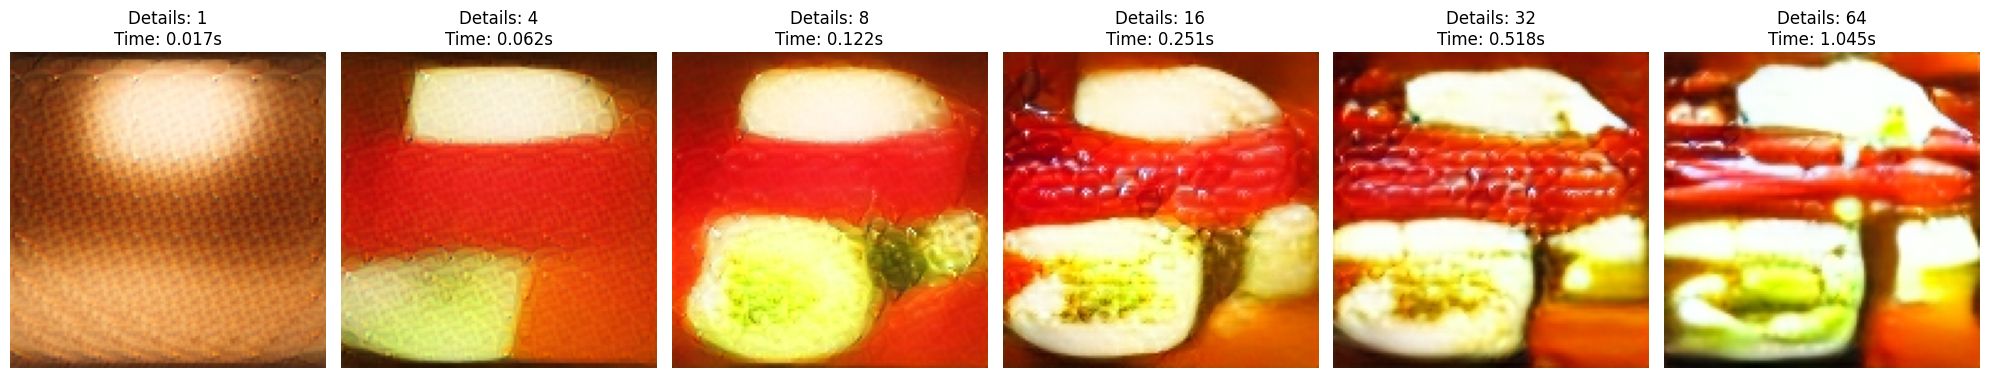

In [58]:
tokens = torch.zeros(1, 341, dtype=torch.int)
tokens[0][0] = 8+207
idx = 0
import time
import matplotlib.pyplot as plt
# Boundaries for each resolution level
# Map token indices to their hierarchical level
LEVEL_RANGES = [
    (0, 1),    # Level 1: class token
    (1, 5),    # Level 2: 2x2 tokens
    (5, 21),   # Level 3: 4x4 tokens
    (21, 85),  # Level 4: 8x8 tokens
    (85, 341)  # Level 5: 16x16 tokens
]

def find_level(i: int) -> int:
    """Returns which hierarchical level (0-5) the token index belongs to."""
    for level, (start, end) in enumerate(LEVEL_RANGES):
        if start <= i < end:
            return level
    return -1

def get_subpatch_indices(i: int) -> list:
    """Returns indices of 4 sub-patches in next level for given token index."""
    level = find_level(i)
    if level >= 4:
        return []
    start = LEVEL_RANGES[level][0]
    next_start = LEVEL_RANGES[level + 1][0]
    offset = i - start
    return [next_start + (offset * 4) + j for j in range(4)]

def generate_next_detail(tokens, idx):
    # Start timing before moving tensors to GPU
    start_time = time.time()
    
    subpatch_indices = get_subpatch_indices(idx)
    tokens[0, subpatch_indices] = 1
    
    # Create unconditioned version with token 2
    uncond_tokens = tokens.clone()
    uncond_tokens[0,0] = 2
    
    # Get logits for both conditioned and unconditioned
    logits = ndpvit.forward(tokens.to("cuda"))
    uncond_logits = ndpvit.forward(uncond_tokens.to("cuda"))
    
    # Apply classifier-free guidance
    guidance_scale = 2.0
    logits = uncond_logits + guidance_scale * (logits - uncond_logits)
    
    level = find_level(idx)
    if level == 0:  # 2x2 level
        valid_range = (1024, 2048)
    elif level == 1:  # 4x4 level 
        valid_range = (2048, 3072)
    elif level == 2:  # 8x8 level
        valid_range = (3072, 4096)
    else:  # 16x16 level
        valid_range = (4096, 5120)
    
    logits_masked = logits[0, subpatch_indices].clone()
    logits_masked[:, :valid_range[0]] = float('-inf')
    logits_masked[:, valid_range[1]:] = float('-inf')
    
    # Implement temperature sampling = 0.5
    temperature = 0.5
    logits_masked = logits_masked / temperature
    
    probs = torch.softmax(logits_masked, dim=-1)
    k = 5
    top_k_probs, top_k_indices = torch.topk(probs, k, dim=-1)
    top_k_probs = top_k_probs / top_k_probs.sum(dim=-1, keepdim=True)
    sampled_indices = torch.multinomial(top_k_probs, num_samples=1).squeeze(-1)
    sampled_tokens = top_k_indices[torch.arange(len(sampled_indices)), sampled_indices]
    tokens[0, subpatch_indices] = sampled_tokens.to(dtype=tokens.dtype, device=tokens.device)
    difficulty = diffvit.forward(tokens.to("cuda"))
    # Create mask for non-zero tokens that have all zero subpatches
    valid_mask = torch.zeros_like(tokens[0], dtype=torch.bool, device=tokens.device)
    for i in range(len(valid_mask)):
        # Check if current token is non-zero
        if tokens[0, i] != 0:
            subpatches = get_subpatch_indices(i)
            if subpatches:  # If token has subpatches
                # Check if all subpatches are zero
                has_all_zeros = all(tokens[0, j] == 0 for j in subpatches)
                valid_mask[i] = has_all_zeros
    
    # Mask difficulty to only consider valid tokens
    masked_difficulty = difficulty[0] * valid_mask.to(difficulty.device)
    
    # Get index of highest valid difficulty
    max_idx = torch.argmax(masked_difficulty)
    
    # Calculate elapsed time after all GPU operations are complete
    torch.cuda.synchronize()  # Wait for all GPU operations to complete
    elapsed = time.time() - start_time
    
    return tokens, max_idx.item(), elapsed

plt.figure(figsize=(20, 4))
total_time = 0
for i in range(64):
    tokens, idx, elapsed = generate_next_detail(tokens, idx)
    total_time += elapsed
    
    if i in [0, 3, 7, 15, 31, 63]:  # Plot at 1, 4, 8, 16, 32, 64 details
        print(f'Time for iteration {i+1}: {elapsed:.2f}s')
        print(f'Total time so far: {total_time:.2f}s')
        print('tokens', tokens)
        # Convert tokens to image
        with torch.no_grad():
            # Get indices for each resolution level
            # Only subtract offsets for non-zero tokens
            level1_tokens = torch.where(tokens[0, 1:5] != 0, tokens[0, 1:5] - 1024, tokens[0, 1:5])  # 2x2
            level2_tokens = torch.where(tokens[0, 5:21] != 0, tokens[0, 5:21] - 2048, tokens[0, 5:21])  # 4x4
            level3_tokens = torch.where(tokens[0, 21:85] != 0, tokens[0, 21:85] - 3072, tokens[0, 21:85])  # 8x8
            level4_tokens = torch.where(tokens[0, 85:341] != 0, tokens[0, 85:341] - 4096, tokens[0, 85:341])  # 16x16
            
            # Convert to codebook entries
            q1 = tokenizer.quantize_1.get_codebook_entry(level4_tokens.to("cuda"), (1, 16, 16, 8))
            q2 = tokenizer.quantize_2.get_codebook_entry(level3_tokens.to("cuda"), (1, 8, 8, 8))
            q3 = tokenizer.quantize_3.get_codebook_entry(level2_tokens.to("cuda"), (1, 4, 4, 8))
            q4 = tokenizer.quantize_4.get_codebook_entry(level1_tokens.to("cuda"), (1, 2, 2, 8))
            
            # Decode image
            img = tokenizer.decode(q1, q2, q3, q4)
            
            # Convert to numpy and normalize
            img = img[0].permute(1,2,0).cpu().numpy()
            img = (img * 0.5 + 0.5).clip(0, 1)
            
            # Plot
            plt.subplot(1, 6, len([x for x in [0,3,7,15,31,63] if x <= i]) )
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Details: {i+1}\nTime: {total_time:.3f}s')

plt.tight_layout()
plt.show()


tokens tensor([[   62,  2293,  8025,   631,  8081, 12495, 12496, 12519, 12496,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,  

tokens tensor([[   62,  2293,  8025,   631,  8081, 12495, 12496, 12519, 12496, 12513,
         12495, 12503, 12496, 12496, 12513, 12496, 12513, 12513, 12503, 12495,
         12503, 16615, 16615, 16615, 16615, 15267, 14582, 16212, 16212, 16615,
         16589, 16589, 16615, 13762, 12902, 15763, 16287, 15134, 16589, 15876,
         12879, 15885, 13876, 16531, 15876, 16589, 16589, 16589, 16589, 15722,
         13876, 13762, 13165, 13876, 15763, 12879, 14771, 13165, 13418, 15763,
         15763, 13876, 16212, 13876, 14926, 14181, 13876, 16372, 14751, 15583,
         13876, 15876, 14751, 15876, 14926, 15722, 13876, 15876, 15876, 13622,
         13239, 13876, 16531, 16531, 13876, 16809, 16980, 18484, 17164, 17215,
         17783, 17392, 17215, 18919, 19406, 18074, 16821, 17164, 16821, 18074,
         18984,     0,     0,     0,     0, 18550, 17052, 16730, 20286,     0,
             0,     0,     0,     0,     0,     0,     0, 19039, 16795, 16698,
         17929, 19673, 17993, 18807, 17172, 1

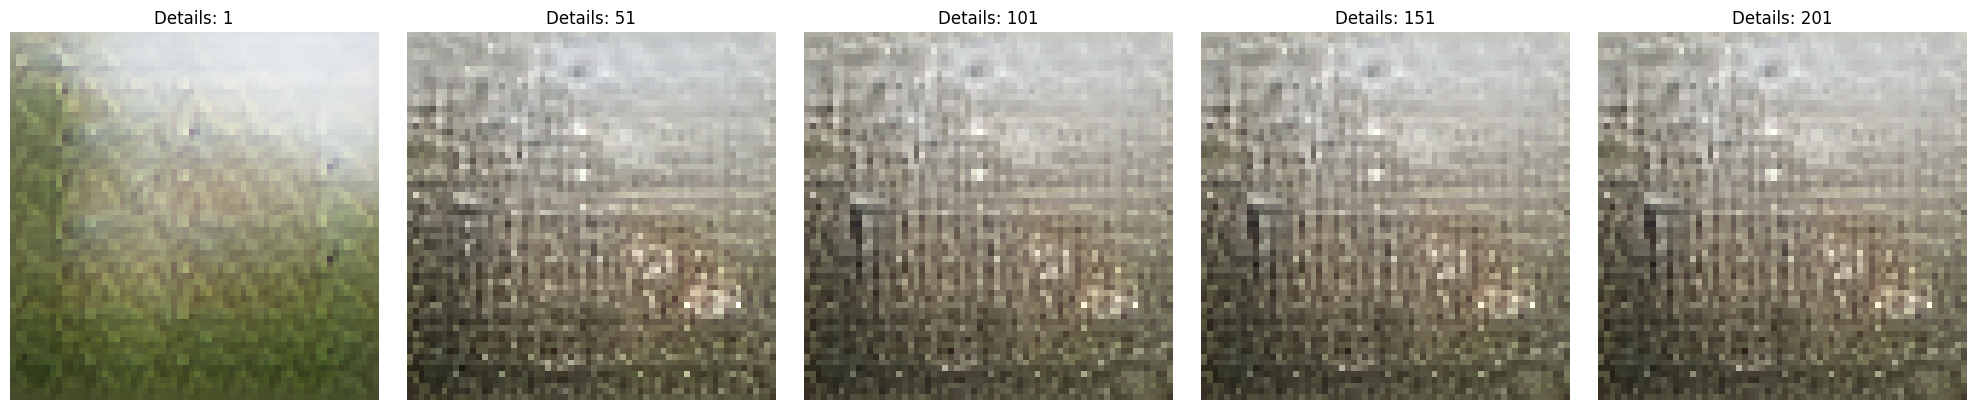

In [54]:
tokens = torch.zeros(1, 341, dtype=torch.int)
tokens[0][0] = 8
idx = 0
import matplotlib.pyplot as plt
# Boundaries for each resolution level
# Map token indices to their hierarchical level
LEVEL_RANGES = [
    (0, 1),    # Level 1: class token
    (1, 5),    # Level 2: 2x2 tokens
    (5, 21),   # Level 3: 4x4 tokens
    (21, 85),  # Level 4: 8x8 tokens
    (85, 341)  # Level 5: 16x16 tokens
]

def find_level(i: int) -> int:
    """Returns which hierarchical level (0-5) the token index belongs to."""
    for level, (start, end) in enumerate(LEVEL_RANGES):
        if start <= i < end:
            return level
    return -1

def get_subpatch_indices(i: int) -> list:
    """Returns indices of 4 sub-patches in next level for given token index."""
    level = find_level(i)
    if level >= 4:
        return []
    start = LEVEL_RANGES[level][0]
    next_start = LEVEL_RANGES[level + 1][0]
    offset = i - start
    return [next_start + (offset * 4) + j for j in range(4)]

def generate_next_detail(tokens, idx):
    subpatch_indices = get_subpatch_indices(idx)
    tokens[0, subpatch_indices] = 1
    logits = ndpvit.forward(tokens.to("cuda"))
    
    level = find_level(idx)
    if level == 0:  # 2x2 level
        valid_range = (1024, 2048)
    elif level == 1:  # 4x4 level 
        valid_range = (2048, 3072)
    elif level == 2:  # 8x8 level
        valid_range = (3072, 4096)
    else:  # 16x16 level
        valid_range = (4096, 5120)
    
    logits_masked = logits[0, subpatch_indices].clone()
    logits_masked[:, :valid_range[0]] = float('-inf')
    logits_masked[:, valid_range[1]:] = float('-inf')
    
    # Implement temperature sampling = 0.5
    temperature = 0.5
    logits_masked = logits_masked / temperature
    
    probs = torch.softmax(logits_masked, dim=-1)
    k = 20
    top_k_probs, top_k_indices = torch.topk(probs, k, dim=-1)
    top_k_probs = top_k_probs / top_k_probs.sum(dim=-1, keepdim=True)
    sampled_indices = torch.multinomial(top_k_probs, num_samples=1).squeeze(-1)
    sampled_tokens = top_k_indices[torch.arange(len(sampled_indices)), sampled_indices]
    tokens[0, subpatch_indices] = sampled_tokens.to(dtype=tokens.dtype, device=tokens.device)
    difficulty = diffvit.forward(tokens.to("cuda"))
    # Create mask for non-zero tokens that have all zero subpatches
    valid_mask = torch.zeros_like(tokens[0], dtype=torch.bool, device=tokens.device)
    for i in range(len(valid_mask)):
        # Check if current token is non-zero
        if tokens[0, i] != 0:
            subpatches = get_subpatch_indices(i)
            if subpatches:  # If token has subpatches
                # Check if all subpatches are zero
                has_all_zeros = all(tokens[0, j] == 0 for j in subpatches)
                valid_mask[i] = has_all_zeros
    
    # Mask difficulty to only consider valid tokens
    masked_difficulty = difficulty[0] * valid_mask.to(difficulty.device)
    
    # Get index of highest valid difficulty
    max_idx = torch.argmax(masked_difficulty)
    
    return tokens, max_idx.item()

plt.figure(figsize=(20, 4))

for i in range(250):
    tokens, idx = generate_next_detail(tokens, idx)
    
    if i % 50 == 0 and i <= 250:  # Plot every 2 iterations
        
        print('tokens', tokens)
        # Convert tokens to image
        with torch.no_grad():
            # Get indices for each resolution level
            # Only subtract offsets for non-zero tokens
            level1_tokens = torch.where(tokens[0, 1:5] != 0, tokens[0, 1:5] - 1024, tokens[0, 1:5])  # 2x2
            level2_tokens = torch.where(tokens[0, 5:21] != 0, tokens[0, 5:21] - 2048, tokens[0, 5:21])  # 4x4
            level3_tokens = torch.where(tokens[0, 21:85] != 0, tokens[0, 21:85] - 3072, tokens[0, 21:85])  # 8x8
            level4_tokens = torch.where(tokens[0, 85:341] != 0, tokens[0, 85:341] - 4096, tokens[0, 85:341])  # 16x16
            
            # Convert to codebook entries
            q1 = tokenizer.quantize_1.get_codebook_entry(level4_tokens.to("cuda"), (1, 16, 16, 8))
            q2 = tokenizer.quantize_2.get_codebook_entry(level3_tokens.to("cuda"), (1, 8, 8, 8))
            q3 = tokenizer.quantize_3.get_codebook_entry(level2_tokens.to("cuda"), (1, 4, 4, 8))
            q4 = tokenizer.quantize_4.get_codebook_entry(level1_tokens.to("cuda"), (1, 2, 2, 8))
            
            # Decode image
            img = tokenizer.decode(q1, q2, q3, q4)
            
            # Convert to numpy and normalize
            img = img[0].permute(1,2,0).cpu().numpy()
            img = (img * 0.5 + 0.5).clip(0, 1)
            
            # Plot
            plt.subplot(1, 5, (i)//50 + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Details: {i+1}')

plt.tight_layout()
plt.show()
